In [1]:
import pandas as pd
from google.colab import drive

In [2]:
import matplotlib.pyplot as plt

In [ ]:
drive.mount("/content/MyDrive/")

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")
drive.mount("/content/MyDrive/")

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [ ]:
place_id_list = ["30","35","36","42","43","44","45","46","47","48","50","51","54","55"]
place_name_list = ["門別","盛岡","水沢","浦和","船橋","大井","川崎","金沢","笠松","名古屋","園田","姫路","高知","佐賀"]
place_name_en_list = ["Monbetsu", "Morioka", "Mizusawa", "Urawa", "Funabashi", "Oi", "Kawasaki", "Kanazawa", "Kasamatsu", "Nagoya", "Sonoda", "Himeji", "Kochi", "Saga"]

In [ ]:
place_df = pd.DataFrame()
place_df["place_id"] = place_id_list
place_df["place_name_jpn"] = place_name_list
place_df["place_name_en"] = place_name_en_list

In [ ]:
place_df.to_csv("/content/MyDrive/MyDrive/horse/data/src/place_name.csv", encoding="utf-8", index=False)

In [ ]:
place_id_list = ["30","35","36","42","43","44","45","46","47","48","50","51","54","55"]
place_id_list2 = [int(id) for id in place_id_list]

# Clean

In [ ]:
for year in range(2019, 2025):
  for place in place_id_list2:
    try:
      horse_df = pd.read_csv("/content/MyDrive/MyDrive/horse/data/src/{}/horse_info_{}.csv".format(year, place), encoding = "utf-8")
      result_df = pd.read_csv("/content/MyDrive/MyDrive/horse/data/src/{}/result_{}.csv".format(year, place), encoding = "utf-8")
      race_info_df = pd.read_csv("/content/MyDrive/MyDrive/horse/data/src/{}/race_info_{}.csv".format(year, place), encoding = "utf-8")


      horse_df["arrival_order"] = horse_df["arrival_order"].replace("除", "1000").replace("中", "1000").replace("失", "1000").replace("取", "1000").replace("2(降)", "1000").astype(float).replace(1000, float("nan"))

      horse_df["sex"] = [sex_age[0] for sex_age in horse_df["sex_age"]]
      horse_df["age"] = [sex_age[1:] for sex_age in horse_df["sex_age"]]
      horse_df["age"] = horse_df["age"].astype(int)

      horse_df["tansho"] = horse_df["tansho"].str.replace("-", "1000").astype(float).replace(1000, float('nan'))

      horse_df["horse_weight"] = horse_df["horse_weight"].replace("計不", "1000(1000)")
      horse_df["horse_weight_today"] = [weight.split("(")[0] for weight in horse_df["horse_weight"]]
      horse_df["horse_weight_today"] = horse_df["horse_weight_today"].astype(float).replace(1000, float('nan'))

      horse_df["horse_weight_diff"] = [weight.split("(")[1].split(")")[0] for weight in horse_df["horse_weight"]]
      horse_df["horse_weight_diff"] = horse_df["horse_weight_diff"].astype(float).replace(1000, float('nan'))

      horse_df["sex_en"] = "male"
      horse_df.loc[horse_df["sex"] == "牝", "sex_en"] = "female"
      horse_df.loc[horse_df["sex"] == "セ", "sex_en"] = "neutering_male"

      horse_df["arrival_time2"] = horse_df["arrival_time"].astype(str)
      horse_df.loc[horse_df["arrival_time2"].str.contains(":") == False, "arrival_time2"] = "1000:1000.0"
      horse_df.loc[horse_df["arrival_time2"]== "nan", "arrival_time2"] = "1000:1000.0"

      horse_df["arrival_time_min"] = [str(time_).split(":")[0] for time_ in horse_df["arrival_time2"]]
      horse_df["arrival_time_min"] = horse_df["arrival_time_min"].replace("nan", "1000").astype(float).replace(1000, float("nan"))

      horse_df["arrival_time_sec"] = [str(time_).split(":")[1] for time_ in horse_df["arrival_time2"]]
      horse_df["arrival_time_sec"] = horse_df["arrival_time_sec"].replace("nan", "1000").astype(float).replace(1000, float("nan"))

      horse_df["arrival_time3"] = 60 * horse_df["arrival_time_min"] + horse_df["arrival_time_sec"]

      horse_df["race_date"] = pd.to_datetime(horse_df["year"].astype(str) + "-" + horse_df["month"].astype(str) + "-" + horse_df["day"].astype(str))
      for i in range(1, 5):
        if "mid_order_{}".format(i) not in horse_df.columns:
          horse_df["mid_order_{}".format(i)] = 0

      horse_df = horse_df[['race_date', 'year', 'month', 'day',
            'place', 'race_id', 'sex_en', 'age', 'frame_id', 'umaban_id', 'horse_name',
            'kinryo_weight', 'jockey', 'arrival_diff', 'tansho',
            'popularity', 'trainer',  'horse_id', 'jockey_id', 'horse_weight_today',
            'horse_weight_diff', 'mid_order_1',
        'mid_order_2', 'mid_order_3', 'mid_order_4', 'arrival_time3', 'arrival_order']]


      horse_df.to_csv("/content/MyDrive/MyDrive/horse/data/dev/{}/horse_info/horse_info_cleaned_{}.csv".format(year, place), encoding = "utf-8", index=False)
      horse_df.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/{}/horse_info/horse_info_cleaned_{}.parquet".format(year, place))



      race_info_df2 = pd.concat([horse_df.drop_duplicates(subset = ["year", "month", "day", "place", "race_id"])[["year", "month", "day", "place", "race_id"]].reset_index(drop = True), race_info_df], axis = 1)

      race_info_df2["race_name"] =  race_info_df2["race_info"].str.split("\n").str[-3]
      race_info_df2["course_type"] =  race_info_df2["race_info"].str.replace("\n", "").str.replace("/", "").str.split("\xa0").str[0].str[0]

      race_info_df2["course_dir"] =  race_info_df2["race_info"].str.replace("\n", "").str.replace("/", "").str.split("\xa0").str[0].str[1]
      race_info_df2["course_len"] =  race_info_df2["race_info"].str.replace("\n", "").str.replace("/", "").str.split("\xa0").str[0].str[2:-1].astype(float)
      race_info_df2["weather"] =  race_info_df2["race_info"].str.replace("\n", "").str.replace("/", "").str.split("\xa0").str[2].str.split(" ").str[0].str[0]
      race_info_df2["course_type"] =  race_info_df2["race_info"].str.replace("\n", "").str.replace("/", "").str.split("\xa0").str[0].str[0]
      race_info_df2["weather"] = race_info_df2["race_info"].str.replace("\n", "").str.replace("/", "").str.split("\xa0").str[2].str.split(" ").str[-1]
      race_info_df2["dirt_status"] = race_info_df2["race_info"].str.replace("\n", "").str.replace("/", "").str.split("\xa0").str[4].str.split(" ").str[-1]
      race_info_df2["race_date"] = pd.to_datetime(race_info_df2["year"].astype(str) + "-" + race_info_df2["month"].astype(str) + "-" + race_info_df2["day"].astype(str))
      race_info_df2 = race_info_df2[["race_date", 'year', 'month', 'day', 'place', 'race_id',
            'race_name', 'course_type', 'course_dir', 'course_len', 'weather',
            'dirt_status', 'race_info', 'race_info2']]

      race_info_df2.to_csv("/content/MyDrive/MyDrive/horse/data/dev/{}/race_info/race_info_cleaned_{}.csv".format(year, place), encoding = "utf-8", index=False)
      race_info_df2.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/{}/race_info/race_info_cleaned_{}.parquet".format(year, place))

      print(year, place)
    except:
      print("E {} {}".format(year, place))

E 2019 30
E 2019 35
E 2019 36
E 2019 42
E 2019 43
E 2019 44
E 2019 45
E 2019 46
E 2019 47
E 2019 48
E 2019 50
E 2019 51
E 2019 54
E 2019 55
E 2020 30
E 2020 35
E 2020 36
E 2020 42
E 2020 43
E 2020 44
E 2020 45
E 2020 46
E 2020 47
E 2020 48
E 2020 50
E 2020 51
E 2020 54
E 2020 55
2021 30
2021 35
2021 36
2021 42
2021 43
2021 44
2021 45
2021 46
E 2021 47
E 2021 48
2021 50
2021 51
2021 54
2021 55
2022 30
2022 35
2022 36
2022 42
2022 43
2022 44
2022 45
2022 46
E 2022 47
E 2022 48
2022 50
2022 51
2022 54
2022 55
2023 30
2023 35
2023 36
2023 42
2023 43
2023 44
2023 45
2023 46
2023 47
2023 48
2023 50
2023 51
2023 54
2023 55
E 2024 30
E 2024 35
E 2024 36
2024 42
E 2024 43
E 2024 44
2024 45
E 2024 46
2024 47
2024 48
2024 50
E 2024 51
2024 54
E 2024 55


# Aggregate

In [ ]:
horse_all_df = pd.DataFrame()
result_all_df = pd.DataFrame()
race_all_df = pd.DataFrame()
for year in range(2021, 2025):
  for place in place_id_list2:
    try:
      horse_df = pd.read_parquet("/content/MyDrive/MyDrive/horse/data/dev/{}/horse_info/horse_info_cleaned_{}.parquet".format(year, place))
      result_df = pd.read_csv("/content/MyDrive/MyDrive/horse/data/src/{}/result_{}.csv".format(year, place), encoding = "utf-8")
      race_info_df = pd.read_parquet("/content/MyDrive/MyDrive/horse/data/dev/{}/race_info/race_info_cleaned_{}.parquet".format(year, place))
      horse_all_df = horse_all_df.append(horse_df, ignore_index=True)
      result_all_df = result_all_df.append(result_df, ignore_index=True)
      race_all_df = race_all_df.append(race_info_df, ignore_index=True)
    except:
      print(year, place)

2021 47
2021 48
2022 47
2022 48
2024 30
2024 35
2024 36
2024 43
2024 44
2024 46
2024 51
2024 55


In [ ]:
horse_all_df.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/horse_info_cleaned_all.parquet")
result_all_df.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/result_cleaned_all.parquet")
race_all_df.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/race_info_cleaned_all.parquet")

In [ ]:
horse_df2 = pd.merge(horse_all_df, race_all_df, on=["race_date", "race_id", "place"], how="left")

In [ ]:
horse_df2.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/horse_race_info_cleaned_all.parquet")

# Construct Variables

In [ ]:
horse_race_df = pd.read_parquet("/content/MyDrive/MyDrive/horse/data/dev/horse_race_info_cleaned_all.parquet")
place_df = pd.read_csv("/content/MyDrive/MyDrive/horse/data/src/place_name.csv")

# Group by and count horses
horse_count_df = horse_race_df.groupby(['race_date', 'race_id', 'place']).size().reset_index(name='horse_count')

# Merge horse_race_df with horse_count_df
horse_race_df2 = pd.merge(horse_race_df, horse_count_df, on=['race_date', 'race_id', 'place'])

# Define mapping functions
def map_course_type(course_type):
    return 'dirt' if course_type == 'ダ' else 'grass'

def map_course_dir(course_dir):
    return 'right' if course_dir == '右' else 'left'

def map_weather(weather):
    mapping = {
        '曇': 'cloudy',
        '雨': 'rainy',
        '晴': 'sunny',
        '小雨': 'little_rainy',
        '雪': 'snowy',
        '小雪': 'little_snowy'
    }
    return mapping.get(weather, weather)

def map_dirt_status(dirt_status):
    mapping = {
        '重': 'heavy',
        '稍重': 'little_heavy',
        '不良': 'bad',
        '良': 'good'
    }
    return mapping.get(dirt_status, dirt_status)

# Apply mapping functions
horse_race_df2['course_type_en'] = horse_race_df2['course_type'].apply(map_course_type)
horse_race_df2['course_dir_en'] = horse_race_df2['course_dir'].apply(map_course_dir)
horse_race_df2['weather_en'] = horse_race_df2['weather'].apply(map_weather)
horse_race_df2['dirt_status_en'] = horse_race_df2['dirt_status'].apply(map_dirt_status)

# Create new columns
horse_race_df2['order_top_1'] = (horse_race_df2['arrival_order'] <= 1).astype(int)
horse_race_df2['order_top_2'] = (horse_race_df2['arrival_order'] <= 2).astype(int)
horse_race_df2['order_top_3'] = (horse_race_df2['arrival_order'] <= 3).astype(int)

# Merge with place_df
horse_race_df2 = pd.merge(horse_race_df2, place_df, left_on='place', right_on='place_id', how='left')

In [ ]:
# interval
horse_race_df2 = horse_race_df2.sort_values(by = ["race_date", "race_id", "place"])
horse_race_df2["horse_interval"] = horse_race_df2.groupby("horse_id")["race_date"].diff().dt.days
horse_race_df2["horse_place_interval"] = horse_race_df2.groupby(["horse_id", "place"])["race_date"].diff().dt.days
horse_race_df2["horse_dir_interval"] = horse_race_df2.groupby(["horse_id", "course_dir"])["race_date"].diff().dt.days
horse_race_df2["horse_len_interval"] = horse_race_df2.groupby(["horse_id", "course_len"])["race_date"].diff().dt.days
horse_race_df2["jockey_interval"] = horse_race_df2.groupby("jockey")["race_date"].diff().dt.days
horse_race_df2["horse_jockey_interval"] = horse_race_df2.groupby(["horse_id", "jockey"])["race_date"].diff().dt.days

In [ ]:
#horse_race_df2["arrival_order_adj"] = horse_race_df2["arrival_order"] / horse_race_df2["horse_count"]
#horse_race_df2["mid_order_1_adj"] = horse_race_df2["mid_order_1"] / horse_race_df2["horse_count"]
#horse_race_df2["mid_order_2_adj"] = horse_race_df2["mid_order_2"] / horse_race_df2["horse_count"]
#horse_race_df2["mid_order_3_adj"] = horse_race_df2["mid_order_3"] / horse_race_df2["horse_count"]
#horse_race_df2["mid_order_4_adj"] = horse_race_df2["mid_order_4"] / horse_race_df2["horse_count"]

In [ ]:
horse_race_df2["h_avg_mid_1"] = horse_race_df2.groupby("horse_id")["mid_order_1"].apply(lambda x: x.rolling(window = 3, min_periods = 1).mean().shift())
horse_race_df2["h_avg_mid_2"] = horse_race_df2.groupby("horse_id")["mid_order_2"].apply(lambda x: x.rolling(window = 3, min_periods = 1).mean().shift())
horse_race_df2["h_avg_final_3"] = horse_race_df2.groupby("horse_id")["arrival_order"].apply(lambda x: x.rolling(window = 3, min_periods = 1).mean().shift())
horse_race_df2["h_avg_final_6"] = horse_race_df2.groupby("horse_id")["arrival_order"].apply(lambda x: x.rolling(window = 6, min_periods = 1).mean().shift())
horse_race_df2["h_prev_final_1"] = horse_race_df2.groupby("horse_id")["arrival_order"].apply(lambda x: x.rolling(window = 1, min_periods = 1).mean().shift())
horse_race_df2["h_prev_mid_1"] = horse_race_df2.groupby("horse_id")["mid_order_1"].apply(lambda x: x.rolling(window = 1, min_periods = 1).mean().shift())
horse_race_df2["h_prev_mid_2"] = horse_race_df2.groupby("horse_id")["mid_order_2"].apply(lambda x: x.rolling(window = 1, min_periods = 1).mean().shift())

In [ ]:
horse_race_df2["j_avg_mid_1"] = horse_race_df2.groupby("jockey")["mid_order_1"].apply(lambda x: x.rolling(window = 3, min_periods = 1).mean().shift())
horse_race_df2["j_avg_mid_2"] = horse_race_df2.groupby("jockey")["mid_order_2"].apply(lambda x: x.rolling(window = 3, min_periods = 1).mean().shift())
horse_race_df2["j_avg_final_3"] = horse_race_df2.groupby("jockey")["arrival_order"].apply(lambda x: x.rolling(window = 3, min_periods = 1).mean().shift())
horse_race_df2["j_avg_final_6"] = horse_race_df2.groupby("jockey")["arrival_order"].apply(lambda x: x.rolling(window = 6, min_periods = 1).mean().shift())
horse_race_df2["j_prev_final_1"] = horse_race_df2.groupby("jockey")["arrival_order"].apply(lambda x: x.rolling(window = 1, min_periods = 1).mean().shift())
horse_race_df2["j_prev_mid_1"] = horse_race_df2.groupby("jockey")["mid_order_1"].apply(lambda x: x.rolling(window = 1, min_periods = 1).mean().shift())
horse_race_df2["j_prev_mid_2"] = horse_race_df2.groupby("jockey")["mid_order_2"].apply(lambda x: x.rolling(window = 1, min_periods = 1).mean().shift())

In [ ]:
horse_race_df2.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/horse_race_info_cleaned_all2.parquet")

In [ ]:
horse_race_df2.drop_duplicates(subset = ["race_date", "race_id", "place"])

,race_date,year_x,month_x,day_x,place,race_id,sex_en,age,frame_id,umaban_id,...,h_prev_final_1,h_prev_mid_1,h_prev_mid_2,j_avg_mid_1,j_avg_mid_2,j_avg_final_3,j_avg_final_6,j_prev_final_1,j_prev_mid_1,j_prev_mid_2
25610,2021-01-01,2021,1,1,45,1,male,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223853,2021-01-01,2021,1,1,48,1,female,4,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59220,2021-01-01,2021,1,1,54,1,female,6,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25622,2021-01-01,2021,1,1,45,2,male,3,8,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223863,2021-01-01,2021,1,1,48,2,male,4,7,7,...,NaN,NaN,NaN,10.000000,NaN,10.000000,10.000000,10.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310875,2024-01-14,2024,1,14,54,6,male,3,3,3,...,7.0,8.0,9.0,9.000000,9.000000,7.333333,5.833333,12.0,12.0,12.0
310882,2024-01-14,2024,1,14,54,7,male,4,5,5,...,1.0,6.0,6.0,6.333333,6.333333,3.666667,3.166667,2.0,4.0,4.0
310890,2024-01-14,2024,1,14,54,8,male,9,1,1,...,2.0,7.0,6.0,4.666667,4.333333,2.333333,2.500000,3.0,4.0,4.0
310899,2024-01-14,2024,1,14,54,9,male,5,2,2,...,1.0,2.0,2.0,4.333333,4.000000,4.000000,5.333333,1.0,4.0,3.0


In [ ]:
horse_name_df = horse_race_df2.drop_duplicates(subset = ["horse_name", "horse_id"])[["horse_name", "horse_id"]].reset_index(drop = True)

In [ ]:
horse_name_df.to_parquet("/content/MyDrive/MyDrive/horse/data/dev/horse_name.parquet")

Text(0, 0.5, 'Horse Weight Diff')

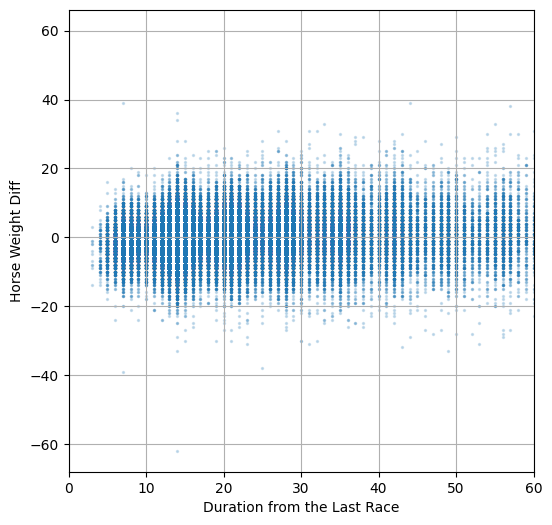

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(horse_race_df2["horse_interval"], horse_race_df2["horse_weight_diff"], s = 2, alpha = 0.2)
ax.grid()
ax.set_xlim([0, 60])
ax.set_xlabel("Duration from the Last Race")
ax.set_ylabel("Horse Weight Diff")